# Market Basket Analysis of Grocery Store

### Importing Dependencies

In [3]:
# Print all the outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Library for Warning Message
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message=".*no associated frequency information.*")
warnings.filterwarnings("ignore", message=".*Maximum Likelihood optimization failed to converge.*")

# Base Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re

# MBA Libraries
from mlxtend.frequent_patterns import apriori, association_rules

### Data Collection and Loading

Data Source - Kaggle (*https://www.kaggle.com/datasets/heeraldedhia/groceries-dataset*)

In [6]:
# Load the data
df = pd.read_csv("groceries_dataset.csv")

### Data Exploration

In [8]:
# View the first 5 rows
df.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


**Data Description**

- Member_number: Customer ID
- Date: Purchase Date / Transaction Date
- itemDescription: Description of product purchased

In [10]:
# Dimension of Data
print("The dataset contains {} rows and {} columns.".format(df.shape[0], df.shape[1]))

The dataset contains 38765 rows and 3 columns.


In [11]:
# Data Type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


In [12]:
# Change the format of 'Date' column to "YYYY-MM-DD" 

# 1. Convert Date to 'datetime'
df['Date'] = pd.to_datetime(df['Date'])

# 2. Create new column for Date only but keep the data type as 'datetime'
df['date'] = df['Date'].dt.floor('D')

# 3. Drop the 'Date' column with incorrect format
df = df.drop(columns = ['Date'])

# Verify
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Member_number    38765 non-null  int64         
 1   itemDescription  38765 non-null  object        
 2   date             38765 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 908.7+ KB


In [13]:
# Check the Missing Data
is_missing = df.isna().any().any()

if is_missing == True:
    print("The dataset contains {} missing values.".format(df.isna().sum().sum()))
else:
    print("The dataset doesn't contain any missing values.")

The dataset doesn't contain any missing values.


### Data Cleansing

Rename the field names to meaningful labels and convert them to lowercase.

In [16]:
df.head()

,Member_number,itemDescription,date
0,1808,tropical fruit,2015-07-21
1,2552,whole milk,2015-01-05
2,2300,pip fruit,2015-09-19
3,1187,other vegetables,2015-12-12
4,3037,whole milk,2015-02-01


In [17]:
df.columns = ['customer_id', 'item_desc', 'date']

# Verify
df.head()

,customer_id,item_desc,date
0,1808,tropical fruit,2015-07-21
1,2552,whole milk,2015-01-05
2,2300,pip fruit,2015-09-19
3,1187,other vegetables,2015-12-12
4,3037,whole milk,2015-02-01


If there is an extra whitespace from item description column, remove it.

In [19]:
df['item_desc'] = df['item_desc'].astype('str').apply(lambda x: re.sub(r'\s+', ' ', x).strip())

### Exploratory Data Analysis (EDA)

What is the duration of the transaction period?

In [22]:
print("The duration of the transaction period is from {} to {}.".format(df['date'].dt.date.min(), df['date'].dt.date.max()))

The duration of the transaction period is from 2014-01-01 to 2015-12-30.


How many customers does the Grocery store has?

In [24]:
print("The Grocery store has {} distinct customers.".format(df['customer_id'].nunique()))

The Grocery store has 3898 distinct customers.


How many distinct products does the Grocery store sells? Also, list the products.

In [26]:
print("The Grocery store has {} distinct products.".format(df['item_desc'].nunique()))
print("List of Distinct Products")
df['item_desc'].unique().tolist()

The Grocery store has 167 distinct products.
List of Distinct Products


['tropical fruit',
 'whole milk',
 'pip fruit',
 'other vegetables',
 'rolls/buns',
 'pot plants',
 'citrus fruit',
 'beef',
 'frankfurter',
 'chicken',
 'butter',
 'fruit/vegetable juice',
 'packaged fruit/vegetables',
 'chocolate',
 'specialty bar',
 'butter milk',
 'bottled water',
 'yogurt',
 'sausage',
 'brown bread',
 'hamburger meat',
 'root vegetables',
 'pork',
 'pastry',
 'canned beer',
 'berries',
 'coffee',
 'misc. beverages',
 'ham',
 'turkey',
 'curd cheese',
 'red/blush wine',
 'frozen potato products',
 'flour',
 'sugar',
 'frozen meals',
 'herbs',
 'soda',
 'detergent',
 'grapes',
 'processed cheese',
 'fish',
 'sparkling wine',
 'newspapers',
 'curd',
 'pasta',
 'popcorn',
 'finished products',
 'beverages',
 'bottled beer',
 'dessert',
 'dog food',
 'specialty chocolate',
 'condensed milk',
 'cleaner',
 'white wine',
 'meat',
 'ice cream',
 'hard cheese',
 'cream cheese',
 'liquor',
 'pickled vegetables',
 'liquor (appetizer)',
 'UHT-milk',
 'candy',
 'onions',
 'hai

Plot the top 5 products based on purchase frequency Vs distinct customers.

/Applications/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Applications/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Applications/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


<Figure size 1200x800 with 0 Axes>

<Axes: >

<BarContainer object of 5 artists>

Text(0.5, 0, 'Products')

Text(0, 0.5, 'Counts')

Text(0.5, 1.0, 'Top 5 Products Popular by Purchase Frequency')

([0, 1, 2, 3, 4],
 [Text(0, 0, 'whole milk'),
  Text(1, 0, 'other vegetables'),
  Text(2, 0, 'rolls/buns'),
  Text(3, 0, 'soda'),
  Text(4, 0, 'yogurt')])

<Axes: >

<BarContainer object of 5 artists>

Text(0.5, 0, 'Products')

Text(0, 0.5, 'Counts')

Text(0.5, 1.0, 'Top 5 Products Popular by Distinct Customers')

([0, 1, 2, 3, 4],
 [Text(0, 0, 'whole milk'),
  Text(1, 0, 'other vegetables'),
  Text(2, 0, 'rolls/buns'),
  Text(3, 0, 'soda'),
  Text(4, 0, 'yogurt')])

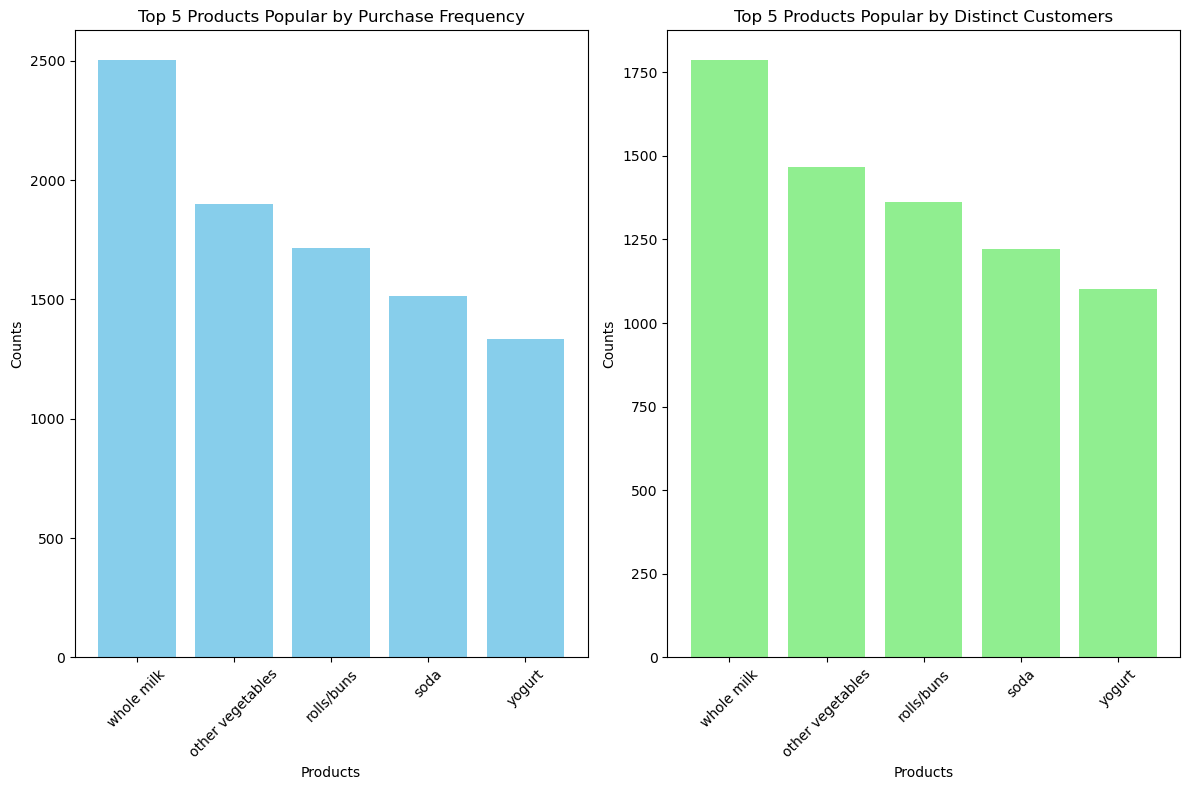

In [28]:
popular_by_purchase_freq = df.groupby('item_desc', as_index = False)[['customer_id']].count().rename(columns = {"customer_id" : "product_count"}).\
sort_values("product_count", ascending = False)
popular_by_purchase_freq = popular_by_purchase_freq.head()

popular_by_diff_customer = df.groupby('item_desc', as_index = False)[['customer_id']].nunique().rename(columns = {"customer_id" : "product_count"}).\
sort_values("product_count", ascending = False)
popular_by_diff_customer = popular_by_diff_customer.head()

# Plot
plt.figure(figsize = (12,8))

plt.subplot(1,2,1)
plt.bar(x = popular_by_purchase_freq['item_desc'], height = popular_by_purchase_freq['product_count'], color = 'skyblue')
plt.xlabel('Products')
plt.ylabel('Counts')
plt.title('Top 5 Products Popular by Purchase Frequency')
plt.xticks(rotation = 45)

plt.subplot(1,2,2)
plt.bar(x = popular_by_diff_customer['item_desc'], height = popular_by_diff_customer['product_count'], color = 'lightgreen')
plt.xlabel('Products')
plt.ylabel('Counts')
plt.title('Top 5 Products Popular by Distinct Customers')
plt.xticks(rotation = 45)

plt.tight_layout()
plt.show()

- Left Chart measures how often products were bought overall (including repeats by the same customer). It highlights repeat demand.
- Right Chart measures how many different customers bought the product. It highlights product reach across customers.

Are there any seasonal products?

,item_desc,mean,std,cv
125,rum,2.388889,1.615893,0.676420
51,finished products,3.500000,2.315953,0.661701
52,fish,1.791667,1.176635,0.656726
101,organic sausage,1.900000,1.197219,0.630115
146,specialty fat,1.909091,1.200379,0.628770


<Figure size 1200x800 with 0 Axes>

Text(0.5, 1.0, 'Top 5 Seasonal Product')

Text(0.5, 0, 'Month')

Text(0, 0.5, 'Avg Purchase')

([<matplotlib.axis.XTick at 0x16208a5d0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12')])

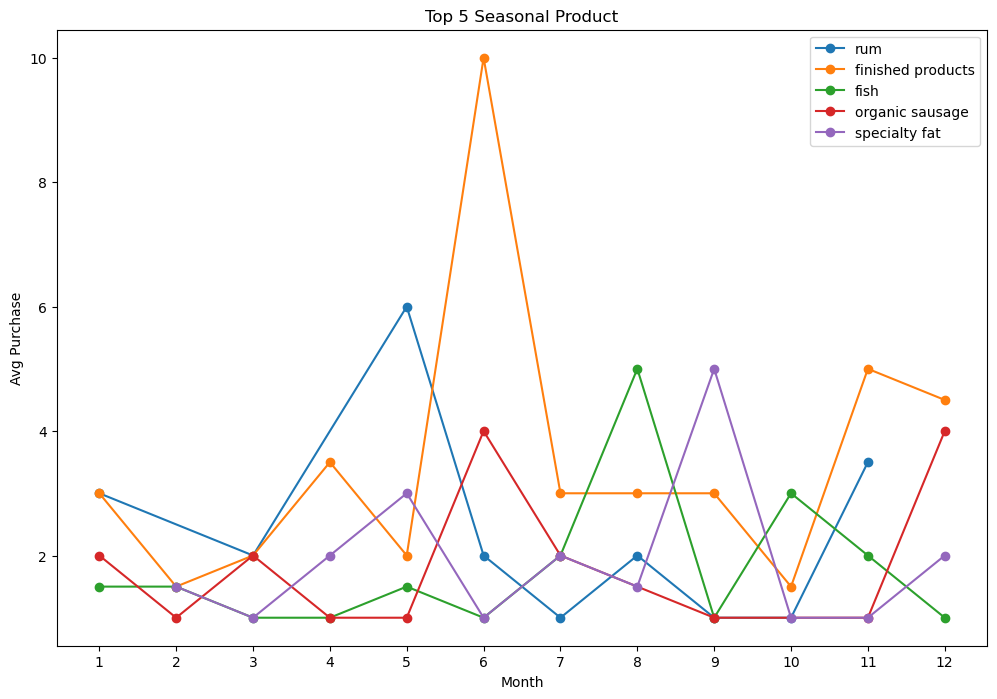

In [31]:
df_eda = df.copy()

df_eda['month'] = df_eda['date'].dt.month
df_eda['year'] = df_eda['date'].dt.year

monthly_count = df_eda.groupby(['item_desc', 'year', 'month'], as_index = False).size().rename(columns = {'size' : 'purchase_count'})
avg_monthly_count = monthly_count.groupby(['item_desc', 'month'], as_index = False)['purchase_count'].mean()

seasonality_stats = avg_monthly_count.groupby('item_desc', as_index = False)['purchase_count'].agg(['mean', 'std'])
seasonality_stats['cv'] = seasonality_stats['std'] / seasonality_stats['mean']

# Top 5 Seasonal Products
top_seasonal = seasonality_stats.sort_values('cv', ascending = False).head(5)
top_seasonal

plt.figure(figsize = (12,8))
for product in top_seasonal['item_desc']:
    subset = avg_monthly_count[avg_monthly_count['item_desc'] == product]
    plt.plot(subset['month'], subset['purchase_count'], marker = 'o', label = product)

plt.title('Top 5 Seasonal Product')
plt.xlabel('Month')
plt.ylabel('Avg Purchase')
plt.xticks(range(1,13))
plt.legend()
plt.show()

**Observations from the Plot**

1. Finished products
    - Huge spike in June (Month 6) → strongly seasonal, maybe linked to summer demand or a festival.
    - Smaller peaks again in November–December, possibly holiday-related.
<br>
2. Rum
    - Noticeable rise around April–May and November.
    - Suggests seasonal demand for celebrations/holidays.
<br>
3. Fish
    - Peaks in August (Month 8).
    - Could be tied to seasonal availability or regional festivals.
<br>
4. Organic sausage
    - Peaks in June and December, which might indicate holiday/festive consumption.
<br>
5. Specialty fat
    - Increases around May and September, with some spikes → possibly tied to cooking during festivals/occasions.
<br>

- These products are not stable staples (like milk or bread), but rather show strong spikes in certain months.
- This means their demand is event/season driven.
- Businesses can use this to:
    - Plan inventory (stock more rum/fish before festive periods).
    - Target promotions/ads before demand spikes.
    - Bundle seasonal products with staples to boost sales.

Which products are popular in specific months?

<Figure size 800x600 with 0 Axes>

Text(0.5, 0.5, 'rolls/buns\n(87)')

Text(0.5, 1.5, 'other vegetables\n(80)')

Text(0.5, 2.5, 'whole milk\n(84)')

Text(0.5, 3.5, 'whole milk\n(98)')

Text(0.5, 4.5, 'rolls/buns\n(89)')

Text(0.5, 5.5, 'whole milk\n(93)')

Text(0.5, 6.5, 'whole milk\n(101)')

Text(0.5, 7.5, 'other vegetables\n(91)')

Text(0.5, 8.5, 'whole milk\n(89)')

Text(0.5, 9.5, 'rolls/buns\n(95)')

Text(0.5, 10.5, 'whole milk\n(88)')

Text(0.5, 11.5, 'whole milk\n(83)')

Text(1.5, 0.5, 'whole milk\n(119)')

Text(1.5, 1.5, 'whole milk\n(115)')

Text(1.5, 2.5, 'whole milk\n(123)')

Text(1.5, 3.5, 'whole milk\n(136)')

Text(1.5, 4.5, 'whole milk\n(128)')

Text(1.5, 5.5, 'whole milk\n(107)')

Text(1.5, 6.5, 'whole milk\n(109)')

Text(1.5, 7.5, 'whole milk\n(145)')

Text(1.5, 8.5, 'whole milk\n(124)')

Text(1.5, 9.5, 'whole milk\n(112)')

Text(1.5, 10.5, 'whole milk\n(140)')

Text(1.5, 11.5, 'whole milk\n(106)')

Text(0.5, 1.0, 'Most Popular Product per Month (by Year)')

Text(70.72222222222221, 0.5, 'Month')

Text(0.5, 36.72222222222221, 'Year')

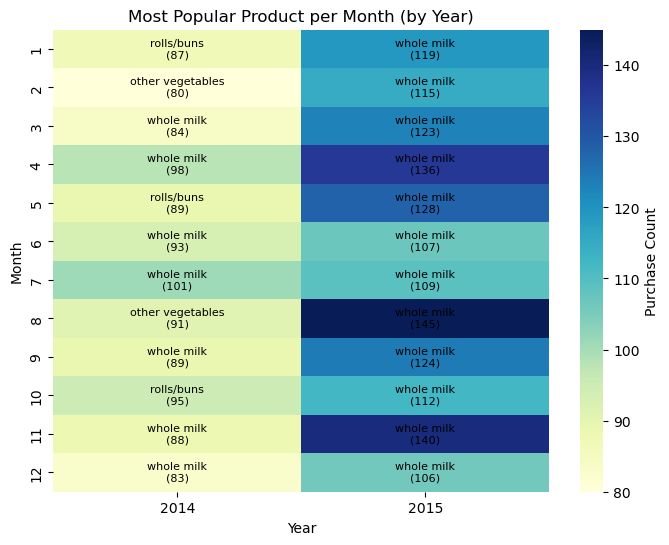

In [34]:
popular_df = df_eda.groupby(['year', 'month', 'item_desc'], as_index = False).size().\
rename(columns = {'size': 'count'}).sort_values(['year', 'month', 'count'], ascending = [True, True, False])

monthly_popular = popular_df.groupby(['year', 'month']).head(1)

# Pivot for heatmap: index=month, columns=year, values=count
heatmap_counts = monthly_popular.pivot_table(
    index="month", columns="year", values="count", aggfunc="first"
)

# Pivot for products
heatmap_products = monthly_popular.pivot_table(
    index="month", columns="year", values="item_desc", aggfunc="first"
)

plt.figure(figsize=(8,6))
ax = sns.heatmap(
    heatmap_counts, 
    annot=False, fmt="d", cmap="YlGnBu", 
    cbar_kws={'label': 'Purchase Count'}
)

# Convert index and columns to lists once
months = heatmap_counts.index.tolist()
years = heatmap_counts.columns.tolist()

# Add product names as text inside the heatmap
for y in years:
    for m in months:
        count_val = heatmap_counts.loc[m, y]
        product = heatmap_products.loc[m, y]
        if pd.notnull(count_val):
            ax.text(
                x=years.index(y) + 0.5,
                y=months.index(m) + 0.5,
                s=f"{product}\n({count_val})",   # show both product + count
                ha='center', va='center', fontsize=8, color="black"
            )

plt.title("Most Popular Product per Month (by Year)")
plt.ylabel("Month")
plt.xlabel("Year")
plt.show()

- 2014: More variety in popular items — sometimes it’s rolls/buns (Jan, May, Oct), sometimes other vegetables (Feb, Aug), but whole milk dominates most months.
- 2015: Whole milk takes over almost every single month — much more dominant compared to 2014.

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Number of Transactions by Month')

Text(0.5, 0, 'Month')

Text(0, 0.5, 'Number of Transactions')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23],
 [Text(0, 0, '2014-01'),
  Text(1, 0, '2014-02'),
  Text(2, 0, '2014-03'),
  Text(3, 0, '2014-04'),
  Text(4, 0, '2014-05'),
  Text(5, 0, '2014-06'),
  Text(6, 0, '2014-07'),
  Text(7, 0, '2014-08'),
  Text(8, 0, '2014-09'),
  Text(9, 0, '2014-10'),
  Text(10, 0, '2014-11'),
  Text(11, 0, '2014-12'),
  Text(12, 0, '2015-01'),
  Text(13, 0, '2015-02'),
  Text(14, 0, '2015-03'),
  Text(15, 0, '2015-04'),
  Text(16, 0, '2015-05'),
  Text(17, 0, '2015-06'),
  Text(18, 0, '2015-07'),
  Text(19, 0, '2015-08'),
  Text(20, 0, '2015-09'),
  Text(21, 0, '2015-10'),
  Text(22, 0, '2015-11'),
  Text(23, 0, '2015-12')])

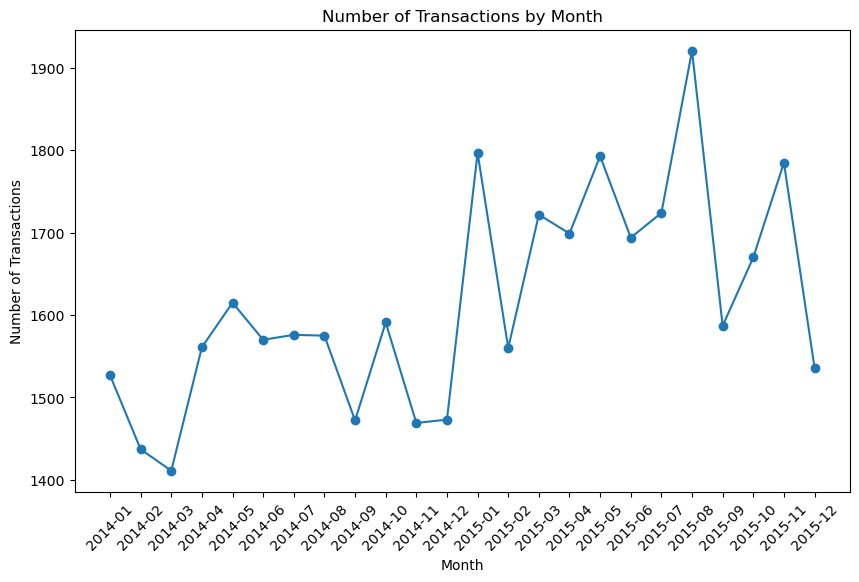

In [36]:
transactions = df[['customer_id', 'date']]
transactions['year_month'] = transactions['date'].dt.to_period('M')
transactions_per_month = transactions.groupby('year_month')['customer_id'].count().reset_index(name='num_transactions')

# Plot
plt.figure(figsize=(10,6))
plt.plot(transactions_per_month['year_month'].astype(str), transactions_per_month['num_transactions'], marker='o', linestyle='-')
plt.title("Number of Transactions by Month")
plt.xlabel("Month")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.show()

### Model Development

#### **Market Basket Analysis (M.B.A.)**

The Market Basket Analysis provides an answer to the question: How likely it is that a customer will buy product A if he/she already has product B in their shopping cart.

**Association Rule**

LHS --> RHS

Association rules are in the form if the product under LHS are present in a transaction then products under RHS are also present with some probability.

**Frequency**

frq(LHS, RHS)

Frequency tells us how often the products on the LHS and RHS occur in a transaction together.

**Support**

frq(LHS, RHS) / N

Where N --> Total number of transactions

Support tells us what percentage of all transactions that is or in other words how likely it is that LHS and RHS occur in a transaction.

**Confidence**

frq(LHS, RHS) / frq(LHS)

Confidence tells us if the products on the LHS occur in an order how likely it is that the products on the RHS are then also in the shopping cart.

**Lift**

Confidence(LHS, RHS) / support(RHS)

Lift indicates the factor by which the probability of buying the products on the RHS increases if the product on the LHS have already been bought.

In [40]:
# Define Basket
df['basket_id'] = df['customer_id'].astype(str) + "_" + df['date'].astype(str)

# Convert into Basket-Item Matrix
basket = df.groupby(['basket_id', 'item_desc']).size().unstack(fill_value = 0)

# Convert counts to 1/0 (Present / Not Present)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# Print the Result
basket.head(10)

item_desc,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
basket_id,,,,,,,,,,,,,,,,,,,,,
1000_2014-06-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1000_2015-03-15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1000_2015-05-27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000_2015-07-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000_2015-11-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1001_2014-02-07,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1001_2014-12-12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1001_2015-01-20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1001_2015-04-14,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [41]:
# Frequent Itemsets using Apriori
frequent_itemsets = apriori(basket, min_support = 0.002, use_colnames = True)

# Only check combinations of 2+ items
print("Multi-item frequent sets:")
print(frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x) > 1)])

/Applications/anaconda3/lib/python3.12/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Multi-item frequent sets:
      support                          itemsets
126  0.002139      (UHT-milk, other vegetables)
127  0.002540            (whole milk, UHT-milk)
128  0.002807          (beef, other vegetables)
129  0.004678                (beef, whole milk)
130  0.002205                    (beef, yogurt)
..        ...                               ...
325  0.002606             (whole milk, waffles)
326  0.004611  (whole milk, whipped/sour cream)
327  0.002941      (yogurt, whipped/sour cream)
328  0.003141         (whole milk, white bread)
329  0.011161              (yogurt, whole milk)

[204 rows x 2 columns]


In [42]:
# Generate Association Rules
rules = association_rules(frequent_itemsets, metric = "confidence", min_threshold = 0.02)

# Sort by Lift
rules = rules.sort_values("lift", ascending = False)

# Print Association Rules
rules = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

In [43]:
# Lift > 1
rules[rules['lift'] > 1]

,antecedents,consequents,support,confidence,lift
148,(curd),(sausage),0.002941,0.087302,1.446615
149,(sausage),(curd),0.002941,0.048726,1.446615
60,(brown bread),(canned beer),0.002406,0.063943,1.362937
59,(canned beer),(brown bread),0.002406,0.051282,1.362937
193,(sausage),(frozen vegetables),0.002072,0.034330,1.225966
192,(frozen vegetables),(sausage),0.002072,0.073986,1.225966
21,(bottled beer),(sausage),0.003342,0.073746,1.222000
22,(sausage),(bottled beer),0.003342,0.055371,1.222000
174,(frankfurter),(other vegetables),0.005146,0.136283,1.116150
173,(other vegetables),(frankfurter),0.005146,0.042146,1.116150


**Sausage Relationships**:
   - Curd --> Sausage has lift 1.447 --> buying curd increases the chance of buying sausage by ~44.7% compared to random.
   - Sausage also shows positive association with **frozen vegetables, bottled beer, yogurt, pastry, and soda**.